In [14]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.filters import threshold_niblack, threshold_sauvola

In [15]:
class GrayscaleNormalizeTransform:
    """Convert BGR → grayscale → normalize [0,1]"""

    def __call__(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = gray.astype(np.float32) / 255.0
        return gray

In [16]:
class MedicalImageDataset:
    def __init__(self, root, transform=None):

        self.root = Path(root)
        self.img_paths = sorted(list((self.root / "images").glob("*.tif")))
        self.mask_paths = sorted(list((self.root / "1st_manual").glob("*.gif")))
        self.transform = transform

        if len(self.img_paths) == 0:
            raise ValueError("No images found. Check dataset path.")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):

        img = cv2.imread(str(self.img_paths[idx]))
        mask = cv2.imread(str(self.mask_paths[idx]), 0)

        if self.transform:
            img = self.transform(img)

        mask = (mask > 0).astype(np.uint8)
        return img, mask

In [17]:
DATA_PATH = r"C:\deep learning for medical imaging\retina img_dataset\DRIVE\training"

dataset = MedicalImageDataset(
    DATA_PATH,
    transform=GrayscaleNormalizeTransform()
)

print("Dataset size:", len(dataset))

Dataset size: 20


In [108]:
def adaptive_niblack_segmentation(image, window=5, k=0.8):

    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    thresh = threshold_niblack(image, window_size=window, k=k)
    binary = (image > thresh).astype(np.uint8)
    return binary


def adaptive_sauvola_segmentation(image, window=5, k=0.05):

    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    thresh = threshold_sauvola(image, window_size=window, k=k)
    binary = (image > thresh).astype(np.uint8)
    return binary

In [19]:
def dice_score(gt, pred):
    inter = np.sum((gt == 1) & (pred == 1))
    return 2 * inter / (np.sum(gt) + np.sum(pred) + 1e-8)


def jaccard_index(gt, pred):
    inter = np.sum((gt == 1) & (pred == 1))
    union = np.sum((gt == 1) | (pred == 1))
    return inter / (union + 1e-8)


def sensitivity_score(gt, pred):
    tp = np.sum((gt == 1) & (pred == 1))
    fn = np.sum((gt == 1) & (pred == 0))
    return tp / (tp + fn + 1e-8)


def specificity_score(gt, pred):
    tn = np.sum((gt == 0) & (pred == 0))
    fp = np.sum((gt == 0) & (pred == 1))
    return tn / (tn + fp + 1e-8)

In [20]:
if len(dataset) == 0:
    raise ValueError("Dataset empty — check path.")

num_samples = min(5, len(dataset))
sample_indices = random.sample(range(len(dataset)), num_samples)


===== Sample 19 =====
Sauvola:
Dice: 0.11046166491620261
Jaccard: 0.058459605113702996
Sensitivity: 0.6772929082833977
Specificity: 0.13217186572620804

Niblack:
Dice: 0.11995582069294619
Jaccard: 0.06380478821362565
Sensitivity: 0.6928922843083505
Specificity: 0.19169790037348652


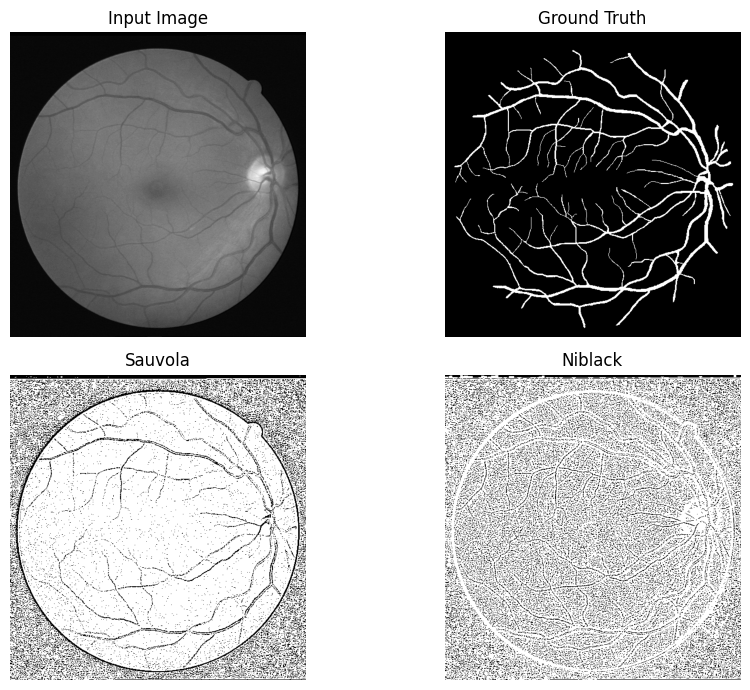


===== Sample 14 =====
Sauvola:
Dice: 0.1309543434343392
Jaccard: 0.0700648178252454
Sensitivity: 0.7079896546900922
Specificity: 0.1355310139771913

Niblack:
Dice: 0.13393121650372553
Jaccard: 0.07177185411825572
Sensitivity: 0.6952327694671133
Specificity: 0.17522598457596614


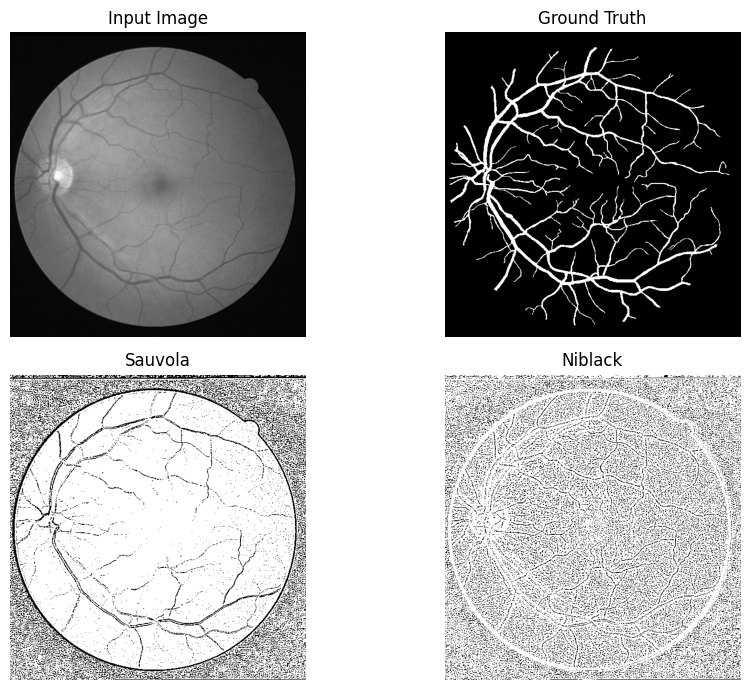


===== Sample 4 =====
Sauvola:
Dice: 0.17641536978722983
Jaccard: 0.09674098304209015
Sensitivity: 0.8871767343456102
Specificity: 0.1325383601918887

Niblack:
Dice: 0.1576690481924434
Jaccard: 0.08558128388265442
Sensitivity: 0.7442293725723123
Specificity: 0.18291198862854785


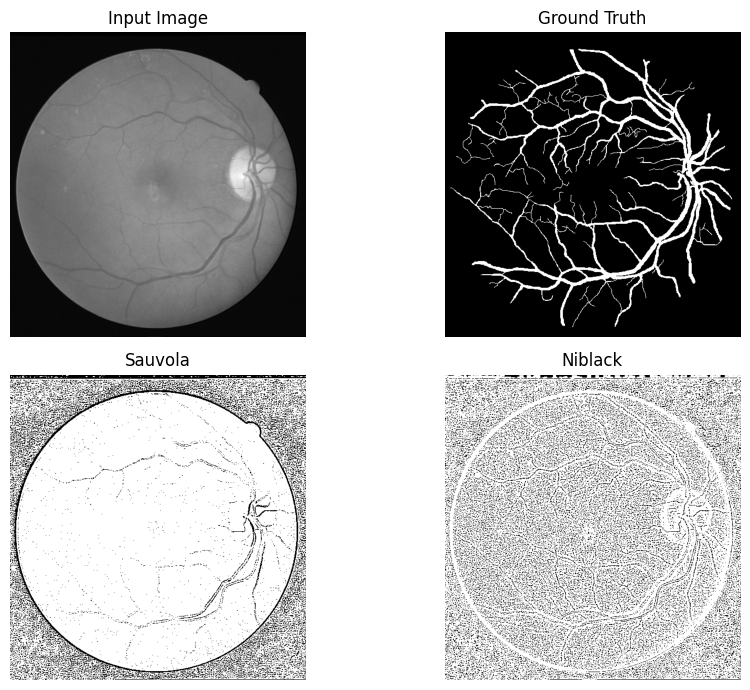


===== Sample 1 =====
Sauvola:
Dice: 0.15290205485536834
Jaccard: 0.08277961396540659
Sensitivity: 0.8082793787108563
Specificity: 0.12959477063211083

Niblack:
Dice: 0.14225229436471934
Jaccard: 0.0765724505718468
Sensitivity: 0.7095172598877153
Specificity: 0.17907986313554913


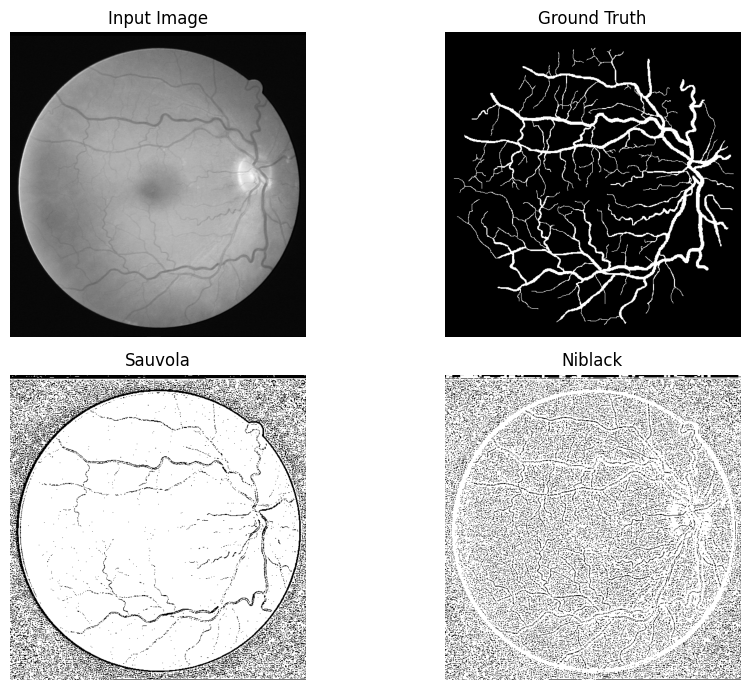


===== Sample 15 =====
Sauvola:
Dice: 0.16740917242821032
Jaccard: 0.09135109153090655
Sensitivity: 0.7361776836471029
Specificity: 0.13866823542213105

Niblack:
Dice: 0.16612387445624768
Jaccard: 0.0905862027114788
Sensitivity: 0.7071954074237246
Specificity: 0.1694051877745831


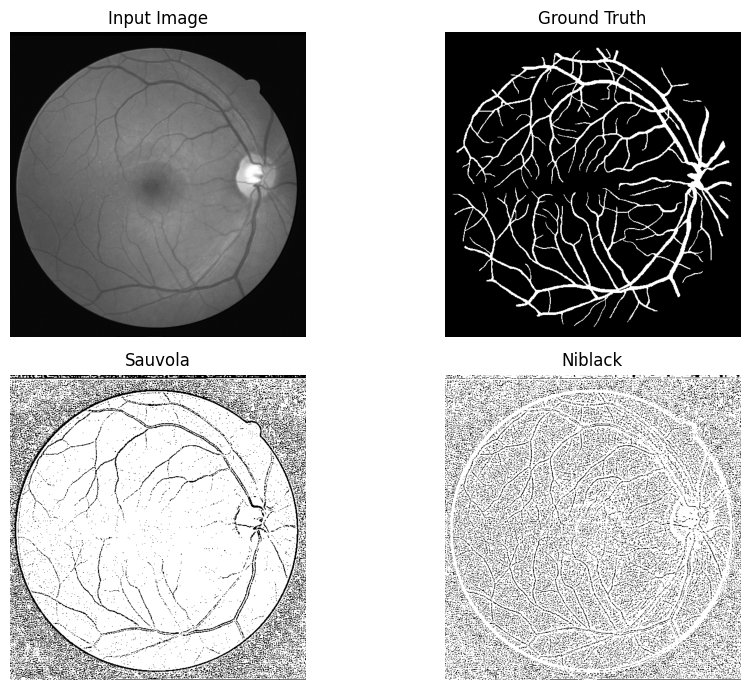

In [109]:
for idx in sample_indices:

    img, mask = dataset[idx]

    pred_sauv = adaptive_sauvola_segmentation(img)
    pred_nib = adaptive_niblack_segmentation(img)

    print(f"\n===== Sample {idx} =====")

    print("Sauvola:")
    print("Dice:", dice_score(mask, pred_sauv))
    print("Jaccard:", jaccard_index(mask, pred_sauv))
    print("Sensitivity:", sensitivity_score(mask, pred_sauv))
    print("Specificity:", specificity_score(mask, pred_sauv))

    print("\nNiblack:")
    print("Dice:", dice_score(mask, pred_nib))
    print("Jaccard:", jaccard_index(mask, pred_nib))
    print("Sensitivity:", sensitivity_score(mask, pred_nib))
    print("Specificity:", specificity_score(mask, pred_nib))

        # Visualization
    plt.figure(figsize=(10,7))

    plt.subplot(2,2,1)
    plt.imshow(img, cmap="gray")
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(2,2,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(2,2,3)
    plt.imshow(pred_sauv, cmap="gray")
    plt.title("Sauvola")
    plt.axis("off")

    plt.subplot(2,2,4)
    plt.imshow(pred_nib, cmap="gray")
    plt.title("Niblack")
    plt.axis("off")

    plt.tight_layout()
    plt.show()